# Proof of concept notebook for the Frame Booster project
- Author: Kamil Barszczak
- Contact: kamilbarszczak62@gmail.com
- Project: https://github.com/kbarszczak/Frame_booster

In [25]:
import matplotlib.pyplot as plt
import tensorflow_addons.image as tfa_image
import tensorflow as tf
import numpy as np
import pickle
import time
import cv2
import os

from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K

In [26]:
# model parameters
model_base_path = 'E:/OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie/Programming/Labs/Frame_booster/models/model_v4'
model_name = 'frame_booster'
width, height = 256, 144

# training data parameters
data_base_path = 'E:/Data/Video_Frame_Interpolation/processed/vimeo90k'
data_creation_time = 1682372054
data_train_size = 19000
data_test_size = 1000
data_valid_size = 1000
batch_size = 5
epochs = 10

# visualization data parameters
vis_base_path = 'E:/Data/Video_Frame_Interpolation/processed/low_motion'
vis_creation_time = '1682179015'
vis_prefix = 'test'

## Load generators for learning

In [27]:
name_to_features = {
    'image_1': tf.io.FixedLenFeature([], tf.string),
    'image_2': tf.io.FixedLenFeature([], tf.string),
    'image_3': tf.io.FixedLenFeature([], tf.string),
}

In [28]:
def parse_decode_record(record):
    features = tf.io.parse_single_example(record, name_to_features)
    image_1 = tf.io.decode_raw(
        features['image_1'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    image_1 = tf.reshape(image_1, (height, width, 3))
    
    image_2 = tf.io.decode_raw(
        features['image_2'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    image_2 = tf.reshape(image_2, (height, width, 3))
    
    image_3 = tf.io.decode_raw(
        features['image_3'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    image_3 = tf.reshape(image_3, (height, width, 3))
    
    return (image_1, image_3), image_2

In [29]:
def load_generator(base_path, prefix, creation_time, width, height, size):
    path = os.path.join(base_path, f'{prefix}_{size}_{height}x{width}_{creation_time}.tfrecords')
    generator = tf.data.TFRecordDataset(path)

    generator = generator.map(parse_decode_record)
    generator = generator.repeat(epochs)
    generator = generator.prefetch(5)
    generator = generator.shuffle(buffer_size=5 * batch_size)
    generator = generator.batch(batch_size, drop_remainder=True)

    return generator

In [30]:
train_generator = load_generator(
    base_path = data_base_path, 
    prefix = 'train',
    creation_time = str(data_creation_time), 
    width = width, 
    height = height, 
    size = str(data_train_size)
)
test_generator = load_generator(
    base_path = data_base_path, 
    prefix = 'test',
    creation_time = str(data_creation_time),
    width = width, 
    height = height, 
    size = str(data_test_size)
)
valid_generator = load_generator(
    base_path = data_base_path, 
    prefix = 'valid',
    creation_time = str(data_creation_time),
    width = width, 
    height = height, 
    size = str(data_valid_size)
)

## Load data for test visualization

In [31]:
def load_data(base_path, prefix, creation_time, width, height):
    with open(os.path.join(base_path, f'x_{prefix}_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_{prefix}_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y = pickle.load(file)
        
    return (np.array(x)/255.0).astype('float32'), (np.array(y)/255.0).astype('float32')

In [32]:
x_vis, y_vis = load_data(
    base_path = vis_base_path,
    prefix = vis_prefix,
    creation_time = vis_creation_time,
    width = width, 
    height = height
)
if len(x_vis) % batch_size != 0:
    x_vis = x_vis[0:len(x_vis) - (len(x_vis)%batch_size)]
    y_vis = y_vis[0:len(x_vis)]

In [33]:
vis_generator = ImageDataGenerator().flow(
    x = [x_vis[:, 0, :, :], x_vis[:, 1, :, :]],
    y = y_vis,
    batch_size = batch_size,
    shuffle = False,
)

## Create activation and loss functions

In [34]:
"""
The output activation returns linear values cropped to range from 0 to 1
"""
def output_activation(x):
    return tf.math.minimum(tf.math.maximum(x, 0), 1)

"""
The L1 reconstruction loss function makes the final image colors 
look the same as the colors in the ground-truth image
"""
def l1(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))


"""
The L2 reconstruction loss function is similar to L1
"""
def l2(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))


"""
The PSNR loss function is responsible for boosting the overall quality of the image by reducing its noise 
(The higher the PSNR the better so we return 1 - PSNR because the loss function tries to minimize it)
"""
def psnr(y_true, y_pred):
    psnr = tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, max_val = 1.0))
    return 1 - psnr / 40.0


"""
The SSIM loss function keeps the result image structure
(The more significant the SSIM the more similar the final image is)
"""
def ssim(y_true, y_pred):
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    return 1 - ssim

"""
The final loss is linear combination of ssim, psnr, l1, l2 losses
"""
def loss(y_true, y_pred):
    ssim_ = ssim(y_true, y_pred)
    psnr_ = psnr(y_true, y_pred)
    l1_ = l1(y_true, y_pred)
    l2_ = l2(y_true, y_pred)
    
    return ssim_ + psnr_ + 5.0*l1_ + 10.0*l2_

## Create and build the model

In [36]:
class BidirectionalFlowEstimation(layers.Layer):
    def __init__(self, filter_count=[32, 64, 64, 16], filter_size=[(3, 3), (3, 3), (1, 1), (1, 1)], activation='relu', regularizer=None, interpolation='bilinear', **kwargs):
        super(BidirectionalFlowEstimation, self).__init__(**kwargs)
        
        assert len(filter_size) == len(filter_count), "filter_size has to have the same length as the filter_count"
        
        # flow 1 -> 2
        self.flow_add_1_2 = layers.Add()
        self.flow_upsample_1_2 = layers.UpSampling2D((2, 2), interpolation=interpolation)
        self.flow_1_2_concat = layers.Concatenate(axis=3)
        
        # flow 2 -> 1
        self.flow_add_2_1 = layers.Add()
        self.flow_upsample_2_1 = layers.UpSampling2D((2, 2), interpolation=interpolation)
        self.flow_2_1_concat = layers.Concatenate(axis=3)
        
        # flow estimation sequentails layers
        self.flow_prediction =  keras.Sequential()
        for fc, fs in zip(filter_count, filter_size):
            self.flow_prediction.add(
                layers.Conv2D(fc, fs, activation=activation, kernel_regularizer=regularizer, padding='same')
            )
        self.flow_prediction.add(layers.Conv2D(2, (1, 1), kernel_regularizer=regularizer, padding='same'))
        
        self.filter_count = filter_count
        self.filter_size = filter_size
        self.activation = activation
        self.regularizer = regularizer
        self.interpolation = interpolation
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "filter_count": self.filter_count,
            "filter_size": self.filter_size,
            "activation": self.activation,
            "regularizer": self.regularizer,
            "interpolation": self.interpolation,
        })
        return config

    def call(self, inputs):
        input_1 = inputs[0]
        input_2 = inputs[1]
        flow_1_2 = inputs[2]
        flow_2_1 = inputs[3]

        if not tf.is_tensor(flow_1_2) or not tf.is_tensor(flow_2_1):
            flow_1_2 = tf.zeros(shape=(batch_size, input_2.shape[1], input_2.shape[2], 2))
            flow_2_1 = tf.zeros(shape=(batch_size, input_2.shape[1], input_2.shape[2], 2))
        
        # input_1 to input_2 flow prediction
        input_1_warped_1 = BidirectionalFlowEstimation.warp(input_1, flow_1_2)
            
        flow_change_1_2_concat = self.flow_1_2_concat([input_2, input_1_warped_1])
        flow_change_1_2 = self.flow_prediction(flow_change_1_2_concat)
        
        flow_1_2_changed = self.flow_add_1_2([flow_1_2, flow_change_1_2])
        input_1_warped_2 = BidirectionalFlowEstimation.warp(input_1, flow_1_2_changed)
        flow_1_2_changed_upsampled = self.flow_upsample_1_2(flow_1_2_changed)
        
        # input_2 to input_1 flow prediction
        input_2_warped_1 = BidirectionalFlowEstimation.warp(input_2, flow_2_1)
        
        flow_change_2_1_concat = self.flow_2_1_concat([input_1, input_2_warped_1])
        flow_change_2_1 = self.flow_prediction(flow_change_2_1_concat)

        flow_2_1_changed = self.flow_add_2_1([flow_2_1, flow_change_2_1])
        input_2_warped_2 = BidirectionalFlowEstimation.warp(input_2, flow_2_1_changed)
        flow_2_1_changed_upsampled = self.flow_upsample_2_1(flow_2_1_changed)
        
        return input_1_warped_2, input_2_warped_2, flow_1_2_changed_upsampled, flow_2_1_changed_upsampled
    
    @staticmethod
    def warp(image: tf.Tensor, flow: tf.Tensor) -> tf.Tensor:
        warped = tf.keras.layers.Lambda(
            lambda x: tfa_image.dense_image_warp(*x))((image, -flow))
        return tf.reshape(warped, shape=tf.shape(image))

In [52]:
# Model parameters
filter_count_col_1 = [64, 48, 32, 16, 8]  # length 5
filter_count_col_2 = [32, 24, 16, 8]  # length 4
filter_count_col_3 = [32, 24, 8]  # length 3
filter_size=(3, 3)

flow_1_filter_count=[40, 80, 80, 24] 
flow_1_filter_size=[(7, 7), (7, 7), (3, 3), (1, 1)]

flow_2_filter_count=[24, 64, 64, 16] 
flow_2_filter_size=[(5, 5), (5, 5), (1, 1), (1, 1)]

flow_3_filter_count=[16, 48, 48, 16] 
flow_3_filter_size=[(3, 3), (3, 3), (1, 1), (1, 1)]

flow_4_filter_count=[8, 32, 32, 8] 
flow_4_filter_size=[(3, 3), (3, 3), (1, 1), (1, 1)]

flow_5_filter_count=[8, 32, 32, 8] 
flow_5_filter_size=[(3, 3), (3, 3), (1, 1), (1, 1)]

interpolation='bilinear'
activation= layers.LeakyReLU(0.2)
regularizer=None

# ------------- Shared conv2d layers
cnn_r1_c1 = layers.Conv2D(filter_count_col_1[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r1_c1")
cnn_r2_c1 = layers.Conv2D(filter_count_col_1[1], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r2_c1")
cnn_r3_c1 = layers.Conv2D(filter_count_col_1[2], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r3_c1")
cnn_r4_c1 = layers.Conv2D(filter_count_col_1[3], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r4_c1")
cnn_r5_c1 = layers.Conv2D(filter_count_col_1[4], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r5_c1")

cnn_r2_c2 = layers.Conv2D(filter_count_col_2[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r2_c2")
cnn_r3_c2 = layers.Conv2D(filter_count_col_2[1], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r3_c2")
cnn_r4_c2 = layers.Conv2D(filter_count_col_2[2], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r4_c2")
cnn_r5_c2 = layers.Conv2D(filter_count_col_2[3], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r5_c2")

cnn_r3_c3 = layers.Conv2D(filter_count_col_3[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r3_c3")
cnn_r4_c3 = layers.Conv2D(filter_count_col_3[1], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r4_c3")
cnn_r5_c3 = layers.Conv2D(filter_count_col_3[2], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name="fe_conv2d_r5_c3")

# ------------- Feature extraction left side
input_1_left = layers.Input(shape=(height, width, 3), name="input_left")
input_2_left = tf.image.resize(input_1_left, size=(height//2, width//2), method=interpolation)
input_3_left = tf.image.resize(input_2_left, size=(height//4, width//4), method=interpolation)
input_4_left = tf.image.resize(input_3_left, size=(height//8, width//8), method=interpolation)
input_5_left = tf.image.resize(input_4_left, size=(height//16, width//16), method=interpolation)

# Feature extraction for layer 1
input_1_left_cnn_r1_c1 = cnn_r1_c1(input_1_left)
input_2_left_cnn_r2_c1 = cnn_r2_c1(input_2_left)
input_3_left_cnn_r3_c1 = cnn_r3_c1(input_3_left)
input_4_left_cnn_r4_c1 = cnn_r4_c1(input_4_left)
input_5_left_cnn_r5_c1 = cnn_r5_c1(input_5_left)

# Downsample layer 1
input_1_left_cnn_r2_c1 = tf.image.resize(input_1_left_cnn_r1_c1, size=(height//2, width//2), method=interpolation)
input_2_left_cnn_r3_c1 = tf.image.resize(input_2_left_cnn_r2_c1, size=(height//4, width//4), method=interpolation)
input_3_left_cnn_r4_c1 = tf.image.resize(input_3_left_cnn_r3_c1, size=(height//8, width//8), method=interpolation)
input_4_left_cnn_r5_c1 = tf.image.resize(input_4_left_cnn_r4_c1, size=(height//16, width//16), method=interpolation)

# Feature extraction for layer 2
input_1_left_cnn_r2_c2 = cnn_r2_c2(input_1_left_cnn_r2_c1)
input_2_left_cnn_r3_c2 = cnn_r3_c2(input_2_left_cnn_r3_c1)
input_3_left_cnn_r4_c2 = cnn_r4_c2(input_3_left_cnn_r4_c1)
input_4_left_cnn_r5_c2 = cnn_r5_c2(input_4_left_cnn_r5_c1)

# Downsample layer 2
input_1_left_cnn_r3_c2 = tf.image.resize(input_1_left_cnn_r2_c2, size=(height//4, width//4), method=interpolation)
input_2_left_cnn_r4_c2 = tf.image.resize(input_2_left_cnn_r3_c2, size=(height//8, width//8), method=interpolation)
input_3_left_cnn_r5_c2 = tf.image.resize(input_3_left_cnn_r4_c2, size=(height//16, width//16), method=interpolation)

# Feature extraction for layer 3
input_1_left_cnn_r3_c3 = cnn_r3_c3(input_1_left_cnn_r3_c2)
input_2_left_cnn_r4_c3 = cnn_r4_c3(input_2_left_cnn_r4_c2)
input_3_left_cnn_r5_c3 = cnn_r5_c3(input_3_left_cnn_r5_c2)

# Concatenate
concat_left_row_2 = layers.Concatenate(name="concat_left_row_2")([input_2_left_cnn_r2_c1, input_1_left_cnn_r2_c2])
concat_left_row_3 = layers.Concatenate(name="concat_left_row_3")([input_3_left_cnn_r3_c1, input_2_left_cnn_r3_c2, input_1_left_cnn_r3_c3])
concat_left_row_4 = layers.Concatenate(name="concat_left_row_4")([input_4_left_cnn_r4_c1, input_3_left_cnn_r4_c2, input_2_left_cnn_r4_c3])
concat_left_row_5 = layers.Concatenate(name="concat_left_row_5")([input_5_left_cnn_r5_c1, input_4_left_cnn_r5_c2, input_3_left_cnn_r5_c3])

# Feature extraction left side output: 
# * input_1_left_cnn_r1_c1
# * concat_left_row_2
# * concat_left_row_3
# * concat_left_row_4
# * concat_left_row_5

# ------------- Feature extraction right side
input_1_right = layers.Input(shape=(height, width, 3), name="input_right")
input_2_right = tf.image.resize(input_1_right, size=(height//2, width//2), method=interpolation)
input_3_right = tf.image.resize(input_2_right, size=(height//4, width//4), method=interpolation)
input_4_right = tf.image.resize(input_3_right, size=(height//8, width//8), method=interpolation)
input_5_right = tf.image.resize(input_4_right, size=(height//16, width//16), method=interpolation)

# Feature extraction for layer 1
input_1_right_cnn_r1_c1 = cnn_r1_c1(input_1_right)
input_2_right_cnn_r2_c1 = cnn_r2_c1(input_2_right)
input_3_right_cnn_r3_c1 = cnn_r3_c1(input_3_right)
input_4_right_cnn_r4_c1 = cnn_r4_c1(input_4_right)
input_5_right_cnn_r5_c1 = cnn_r5_c1(input_5_right)

# Downsample layer 1
input_1_right_cnn_r2_c1 = tf.image.resize(input_1_right_cnn_r1_c1, size=(height//2, width//2), method=interpolation)
input_2_right_cnn_r3_c1 = tf.image.resize(input_2_right_cnn_r2_c1, size=(height//4, width//4), method=interpolation)
input_3_right_cnn_r4_c1 = tf.image.resize(input_3_right_cnn_r3_c1, size=(height//8, width//8), method=interpolation)
input_4_right_cnn_r5_c1 = tf.image.resize(input_4_right_cnn_r4_c1, size=(height//16, width//16), method=interpolation)

# Feature extraction for layer 2
input_1_right_cnn_r2_c2 = cnn_r2_c2(input_1_right_cnn_r2_c1)
input_2_right_cnn_r3_c2 = cnn_r3_c2(input_2_right_cnn_r3_c1)
input_3_right_cnn_r4_c2 = cnn_r4_c2(input_3_right_cnn_r4_c1)
input_4_right_cnn_r5_c2 = cnn_r5_c2(input_4_right_cnn_r5_c1)

# Downsample layer 2
input_1_right_cnn_r3_c2 = tf.image.resize(input_1_right_cnn_r2_c2, size=(height//4, width//4), method=interpolation)
input_2_right_cnn_r4_c2 = tf.image.resize(input_2_right_cnn_r3_c2, size=(height//8, width//8), method=interpolation)
input_3_right_cnn_r5_c2 = tf.image.resize(input_3_right_cnn_r4_c2, size=(height//16, width//16), method=interpolation)

# Feature extraction for layer 3
input_1_right_cnn_r3_c3 = cnn_r3_c3(input_1_right_cnn_r3_c2)
input_2_right_cnn_r4_c3 = cnn_r4_c3(input_2_right_cnn_r4_c2)
input_3_right_cnn_r5_c3 = cnn_r5_c3(input_3_right_cnn_r5_c2)

# Concatenate
concat_right_row_2 = layers.Concatenate(name="concat_right_row_2")([input_2_right_cnn_r2_c1, input_1_right_cnn_r2_c2])
concat_right_row_3 = layers.Concatenate(name="concat_right_row_3")([input_3_right_cnn_r3_c1, input_2_right_cnn_r3_c2, input_1_right_cnn_r3_c3])
concat_right_row_4 = layers.Concatenate(name="concat_right_row_4")([input_4_right_cnn_r4_c1, input_3_right_cnn_r4_c2, input_2_right_cnn_r4_c3])
concat_right_row_5 = layers.Concatenate(name="concat_right_row_5")([input_5_right_cnn_r5_c1, input_4_right_cnn_r5_c2, input_3_right_cnn_r5_c3])

# Feature extraction right side output: 
# * input_1_right_cnn_r1_c1
# * concat_right_row_2
# * concat_right_row_3
# * concat_right_row_4
# * concat_right_row_5

# Flow estimation layers     
bidirectional_flow_estimation_row_1 = BidirectionalFlowEstimation(
    filter_count=flow_1_filter_count, 
    filter_size=flow_1_filter_size, 
    activation=activation, 
    regularizer=regularizer, 
    interpolation=interpolation,
    name="bflow_row_1"
)
bidirectional_flow_estimation_row_2 = BidirectionalFlowEstimation(
    filter_count=flow_2_filter_count, 
    filter_size=flow_2_filter_size, 
    activation=activation, 
    regularizer=regularizer, 
    interpolation=interpolation,
    name="bflow_row_2"
)
bidirectional_flow_estimation_row_3 = BidirectionalFlowEstimation(
    filter_count=flow_3_filter_count, 
    filter_size=flow_3_filter_size, 
    activation=activation, 
    regularizer=regularizer, 
    interpolation=interpolation,
    name="bflow_row_3"
)
bidirectional_flow_estimation_row_4 = BidirectionalFlowEstimation(
    filter_count=flow_4_filter_count, 
    filter_size=flow_4_filter_size, 
    activation=activation, 
    regularizer=regularizer, 
    interpolation=interpolation,
    name="bflow_row_4"
)
bidirectional_flow_estimation_row_5 = BidirectionalFlowEstimation(
    filter_count=flow_5_filter_count, 
    filter_size=flow_5_filter_size, 
    activation=activation, 
    regularizer=regularizer, 
    interpolation=interpolation,
    name="bflow_row_5"
)

# ------------- Warping features at each level
empty_flow_1 = tf.zeros(shape=(batch_size, height//16, width//16, 2))
empty_flow_2 = tf.zeros(shape=(batch_size, height//16, width//16, 2))

# Calculate the flow for each level using the input of current level and the upsampled flow from the level + 1
bfe_5_i1, bfe_5_i2, bfe_5_f_1_2, bfe_5_f_2_1 = bidirectional_flow_estimation_row_5([concat_left_row_5, concat_right_row_5, empty_flow_1, empty_flow_2])
bfe_4_i1, bfe_4_i2, bfe_4_f_1_2, bfe_4_f_2_1 = bidirectional_flow_estimation_row_4([concat_left_row_4, concat_right_row_4, bfe_5_f_1_2, bfe_5_f_2_1])
bfe_3_i1, bfe_3_i2, bfe_3_f_1_2, bfe_3_f_2_1 = bidirectional_flow_estimation_row_3([concat_left_row_3, concat_right_row_3, bfe_4_f_1_2, bfe_4_f_2_1])
bfe_2_i1, bfe_2_i2, bfe_2_f_1_2, bfe_2_f_2_1 = bidirectional_flow_estimation_row_2([concat_left_row_2, concat_right_row_2, bfe_3_f_1_2, bfe_3_f_2_1])
bfe_1_i1, bfe_1_i2, _, _ = bidirectional_flow_estimation_row_1([input_1_left_cnn_r1_c1, input_1_right_cnn_r1_c1, bfe_2_f_1_2, bfe_2_f_2_1])

# Flow estimation output: 
# * (bfe_1_i1, bfe_2_i1, bfe_3_i1, bfe_4_i1, bfe_5_i1) 
# * (bfe_1_i2, bfe_2_i2, bfe_3_i2, bfe_4_i2, bfe_5_i2)

# ------------- Warped features fusion   
        
# merge row 5
add_row_5 = layers.Add(name='add_row_5')([bfe_5_i1, bfe_5_i2])
cnn_row_5_1 = layers.Conv2D(filter_count_col_1[3] + filter_count_col_2[2] + filter_count_col_3[1], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name='fus_conv2d_row_5_1')(add_row_5)
upsample_row_5 = layers.UpSampling2D((2, 2), interpolation=interpolation, name="upsample_row_5")(cnn_row_5_1)

# merge row 4
add_row_4 = layers.Add(name='add_row_4')([bfe_4_i1, bfe_4_i2, upsample_row_5])
cnn_row_4_1 = layers.Conv2D(filter_count_col_1[2] + filter_count_col_2[1] + filter_count_col_3[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name='fus_conv2d_row_4_1')(add_row_4)
upsample_row_4 = layers.UpSampling2D((2, 2), interpolation=interpolation, name="upsample_row_4")(cnn_row_4_1)

# merge row 3
add_row_3 = layers.Add(name='add_row_3')([bfe_3_i1, bfe_3_i2, upsample_row_4])
cnn_row_3_1 = layers.Conv2D(filter_count_col_1[1] + filter_count_col_2[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name='fus_conv2d_row_3_1')(add_row_3)
upsample_row_3 = layers.UpSampling2D((2, 2), interpolation=interpolation, name="upsample_row_3")(cnn_row_3_1)

# merge row 2
add_row_2 = layers.Add(name='add_row_2')([bfe_2_i1, bfe_2_i2, upsample_row_3])
cnn_row_2_1 = layers.Conv2D(filter_count_col_1[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name='fus_conv2d_row_2_1')(add_row_2)
cnn_row_2_2 = layers.Conv2D(filter_count_col_1[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name='fus_conv2d_row_2_2')(cnn_row_2_1)
upsample_row_2 = layers.UpSampling2D((2, 2), interpolation=interpolation, name="upsample_row_2")(cnn_row_2_2)

# merge row 1
add_row_1 = layers.Add(name='add_row_1')([bfe_1_i1, bfe_1_i2, upsample_row_2])
cnn_row_1_1 = layers.Conv2D(filter_count_col_1[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name='fus_conv2d_row_1_1')(add_row_1)
cnn_row_1_2 = layers.Conv2D(filter_count_col_1[0], filter_size, activation=activation, kernel_regularizer=regularizer, padding='same', name='fus_conv2d_row_1_2')(cnn_row_1_1)
fus_conv2d_outputs = layers.Conv2D(3, (1, 1), activation=output_activation, padding='same', name="fus_conv2d_outputs")(cnn_row_1_2)

model = keras.Model(inputs=[input_1_left, input_1_right], outputs=fus_conv2d_outputs)
model.compile()
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 144, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_right (InputLayer)       [(None, 144, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.resize_312 (TFOpLambd  (None, 72, 128, 3)  0           ['input_left[0][0]']             
 a)                                                                                        

                                                                  'fe_conv2d_r5_c3[0][0]']        
                                                                                                  
 concat_right_row_5 (Concatenat  (None, 9, 16, 24)   0           ['fe_conv2d_r5_c1[1][0]',        
 e)                                                               'fe_conv2d_r5_c2[1][0]',        
                                                                  'fe_conv2d_r5_c3[1][0]']        
                                                                                                  
 fe_conv2d_r1_c1 (Conv2D)       (None, 144, 256, 64  1792        ['input_left[0][0]',             
                                )                                 'input_right[0][0]']            
                                                                                                  
 tf.image.resize_321 (TFOpLambd  (None, 18, 32, 24)  0           ['fe_conv2d_r3_c2[0][0]']        
 a)       

                                                                  'bflow_row_3[0][1]',            
                                                                  'upsample_row_4[0][0]']         
                                                                                                  
 concat_left_row_2 (Concatenate  (None, 72, 128, 80)  0          ['fe_conv2d_r2_c1[0][0]',        
 )                                                                'fe_conv2d_r2_c2[0][0]']        
                                                                                                  
 concat_right_row_2 (Concatenat  (None, 72, 128, 80)  0          ['fe_conv2d_r2_c1[1][0]',        
 e)                                                               'fe_conv2d_r2_c2[1][0]']        
                                                                                                  
 fus_conv2d_row_3_1 (Conv2D)    (5, 36, 64, 80)      63440       ['add_row_3[0][0]']              
          

## Train the model

In [23]:
def fit(model, train_generator, train_size, valid_generator, valid_size, optimizer, loss, metrics, epochs, batch_size, save_freq=50, log_freq=10, bad_input_limit=5, mode="all"):
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True)
            loss_value = loss(y, y_pred)

        if not tf.math.is_nan(loss_value):
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return loss_value, y_pred
    
    
    @tf.function
    def calc_metrics(x, y):
        y_pred = model(x, training=False)
        return [metric(y, y_pred) for metric in metrics]

    
    @tf.function
    def valid_step(x, y):
        y_pred = model(x, training=False)
        return loss(y, y_pred)
    
    
    def get_loss_metrics_str(loss_value, metrics_values, sep=' '):
        result = 'loss=' + '{:.5f}'.format(loss_value)
        for metric_value, metric in zip(metrics_values, metrics):
            result += f'{sep}{metric.__name__}='+'{:.5f}'.format(metric_value)
        return result

    
    # create dict for a history and a list for bad input
    history = {metric.__name__: [] for metric in metrics}
    history = history | {"val_" + metric.__name__: [] for metric in metrics}
    history[loss.__name__] = []
    history["val_" + loss.__name__] = []
    bad_input = []
    best_loss = None
    
    try:
        # loop over epochs
        for epoch in range(1, epochs+1):
            print(f"Epoch: {epoch}/{epochs}")

            # process the full training dataset
            total_metrics = np.zeros(len(metrics))
            total_loss = 0
            batch_index = 1.0
            for step, record in enumerate(train_generator):
                # extract the data
                x = record[0]
                y = record[1]

                # calculate metrics values, the loss and then apply the gradient change if loss is not NaN
                loss_value, y_pred = train_step(x, y)
                metrics_values = np.array(calc_metrics(x, y))
                
                # is loss was NaN save the bad input and get to next iteration
                if tf.math.is_nan(loss_value):
                    print(f"Loss NaN detected at epoch {epoch} in step {(step+1)}. Wrong data saved to bad_input list")
                    bad_input.append((x, y, y_pred))
                    if len(bad_input) >= bad_input_limit:
                        raise OverflowError(f"The bad_input limit of {bad_input_limit} was reached")
                    continue

                # save the loss & metrics values
                total_loss += loss_value
                total_metrics += metrics_values

                # save the model
                if step % save_freq == 0:
                    loss_avg = total_loss / batch_index
                    if mode == "all" or (mode == "best" and (best_loss is None or best_loss > loss_avg)):
                        print("Saving model with loss " + '{:.5f}'.format(loss_avg))
                        model.save(os.path.join(model_base_path, f'{model_name}_{get_loss_metrics_str(loss_avg, total_metrics/batch_index, sep="_")}_e={(epoch+1)}_s={(step+1)}_t={int(time.time())}.h5'))
                        best_loss = loss_avg

                # log the loss
                if step % log_freq == 0:
                    ljust_length = len(str(train_size//batch_size)) * 2 + 2
                    prefix = 'Step ' + f'{(step+1)}/{(train_size//batch_size)}: '.rjust(ljust_length)
                    print(f'{prefix}{get_loss_metrics_str(total_loss/batch_index, total_metrics/batch_index)}')

                # break the learning if the generator is over
                if step >= ((train_size // batch_size) - 1):
                    break
                
                batch_index += 1.0

            # save the loss value
            history[loss.__name__].append(total_loss / batch_index)
            for index, metric in enumerate(metrics):
                history[metric.__name__].append(total_metrics[index] / batch_index)

            # process the full validating dataset
            total_loss = 0
            total_metrics = np.zeros(len(metrics))
            batch_index = 1.0
            for step, record in enumerate(valid_generator):
                x = record[0]
                y = record[1]

                total_loss += valid_step(x, y)
                total_metrics += np.array(calc_metrics(x, y))

                if step >= ((valid_size // batch_size) - 1):
                    break

                batch_index += 1.0

            # log the validation score
            print(f'Validation for epoch {epoch}: {get_loss_metrics_str(total_loss/batch_index, total_metrics/batch_index)}')

            # save the validation score
            history["val_" + loss.__name__].append(total_loss/batch_index)
            for index, metric in enumerate(metrics):
                history["val_" + metric.__name__].append(total_metrics[index]/batch_index)
    except (OverflowError, KeyboardInterrupt) as e:
        print(f"Learning interrupted. Details: '{e}'")
    
    return history, bad_input

In [ ]:
history, bad_input = fit(
    model=model, 
    train_generator=train_generator,
    train_size=data_train_size, 
    valid_generator=valid_generator,
    valid_size=data_valid_size,
    optimizer=optimizers.Nadam(0.0005, clipnorm=0.5), 
    loss=loss, 
    metrics=[l1, l2, psnr, ssim],
    epochs=epochs, 
    batch_size=batch_size, 
    save_freq=50,
    log_freq=10,
    bad_input_limit=5,
    mode="best"
)

Epoch: 1/10
Saving model with loss 1.23531
Step   1/3800: loss=1.23531 l1=0.06629 l2=0.00932 psnr=0.46479 ssim=0.37157
Step  11/3800: loss=0.89503 l1=0.04429 l2=0.00490 psnr=0.38639 ssim=0.22353
Step  21/3800: loss=0.87192 l1=0.04180 l2=0.00453 psnr=0.37998 ssim=0.22126
Step  31/3800: loss=0.87169 l1=0.04193 l2=0.00448 psnr=0.38167 ssim=0.22228
Step  41/3800: loss=0.88683 l1=0.04239 l2=0.00469 psnr=0.38779 ssim=0.22477
Saving model with loss 0.88013
Step  51/3800: loss=0.88013 l1=0.04216 l2=0.00463 psnr=0.38608 ssim=0.22361
Learning interrupted. Details: ''


## Evaluate the training

In [16]:
def norm_0_1(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def norm(data):
    return (data - np.mean(data)) / np.std(data)

In [17]:
def plot_history(history, normalize_method=None, metrics_restrictions=None):
    plt.clf()
    plt.figure(figsize=(25,10))
    
    metrics = list(history.keys())
    metrics = [metric for metric in metrics if "val" not in metric]
    if metrics_restrictions is not None:
        metrics = [metric for metric in metrics if metric in metrics_restrictions]
    
    data = [(index, history[metric], history['val_'+metric], metric) for index, metric in enumerate(metrics)]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    epochs = range(1, len(data[0][1]) + 1)
    
    for index, value, val_value, metric in data:
        if normalize_method is not None:
            buffer = value.copy()
            buffer.extend(val_value)
            buffer = normalize_method(buffer)
            value = buffer[0:len(epochs)]
            val_value = buffer[len(epochs)::]
        
        plt.plot(epochs, value, colors[index], label=f"Training {metric}")
        plt.plot(epochs, val_value, colors[index]+'--', label=f"Validation {metric}")
        
    plt.xticks(epochs, size=17)    
    plt.yticks(size=17)
    plt.title(f"Comparison of Training and Validation metrics", size=20)
    plt.xlabel('Epochs', size=17)
    plt.ylabel("Metric values", size=17)
    plt.legend(loc='upper right', fontsize=14)
    plt.show()

In [18]:
def evaluate(model, generator, verbose=0):
    result_dict = {}
    result = model.evaluate(generator, verbose=verbose, steps=data_test_size//batch_size)
    for index, metric in enumerate(model.metrics):
        result_dict[metric.name] = result[index]
        print(f'{metric.name.zfill(13).replace("0", " ")}: {np.round(result[index], 4)}')
        
    return result_dict

C:\Users\Kamil\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Kamil\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Kamil\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Kamil\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Kamil\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

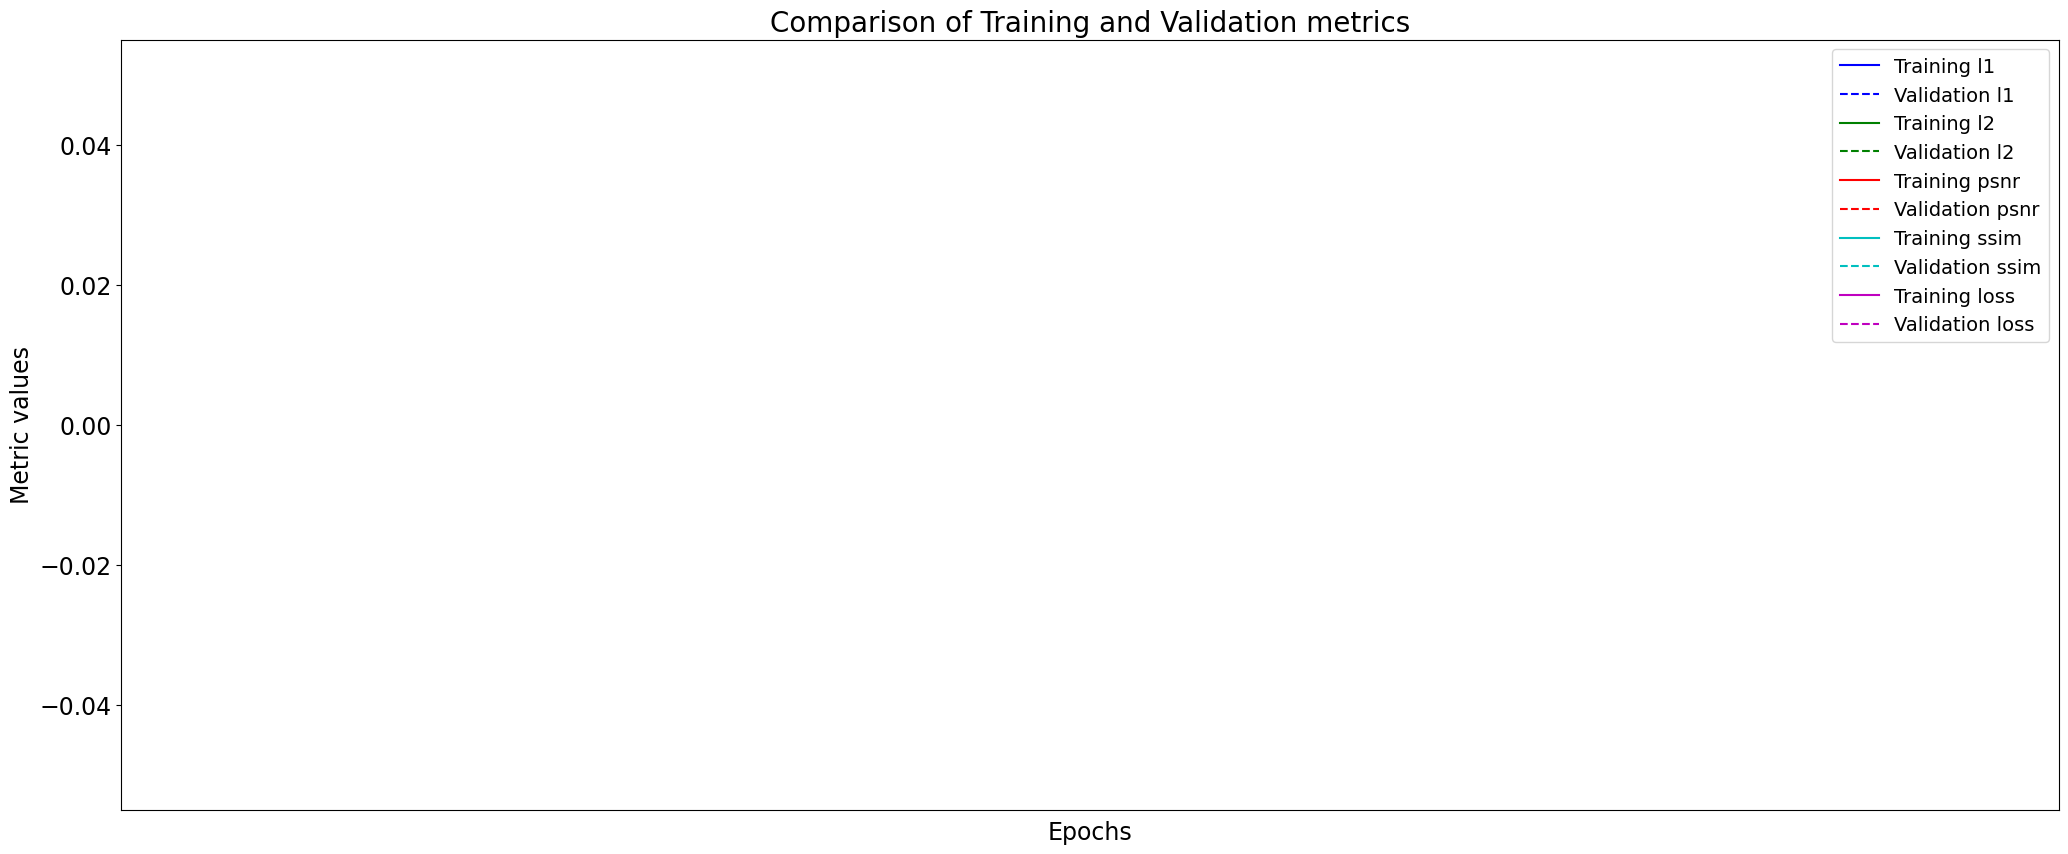

In [19]:
plot_history(history, normalize_method=norm)

In [ ]:
plot_history(history, normalize_method=norm_0_1)

In [ ]:
plot_history(history, normalize_method=None, metrics_restrictions=['loss'])

In [ ]:
_ = evaluate(model, test_generator, verbose=1)

## Visualize generated frames

In [ ]:
predictions = model.predict(vis_generator)

In [ ]:
def visualize(generator, predictions, batch, index):
    # verify arguments
    batch_size = generator.batch_size
    assert generator.shuffle == False
    assert batch >= 0 and batch < len(generator)
    assert index >= 0 and index < batch_size
    
    # get neighbours frames
    neighbours, true = generator[batch]
    neighbours = np.array(neighbours)
    neighbours = neighbours[:, index, :, :, :]

    # get true and predicted frames
    true = np.array(true)[index]
    predicted = predictions[batch_size*batch + index]
    
    # mark true edges on predicted frame
    true_edges = cv2.cvtColor(true, cv2.COLOR_RGB2GRAY)
    true_edges = cv2.GaussianBlur(true_edges, (3, 3), 1)
    true_edges = cv2.medianBlur(true_edges, 3)
    true_edges = cv2.Canny((true_edges*255).astype('uint8'), 50, 100)
    predicted_marked = predicted.copy()
    predicted_marked[true_edges != 0] = (1, 1, 1)

    # plot images
    f, ax = plt.subplots(3, 2)
    f.set_size_inches(20, 20)

    ax[0][0].set_title("First frame")
    ax[0][0].set_xticks([])
    ax[0][0].set_yticks([])
    ax[0][0].imshow(neighbours[0])
    
    ax[1][0].set_title("Predicted frame")
    ax[1][0].set_xticks([])
    ax[1][0].set_yticks([])
    ax[1][0].imshow(predicted)
    
    ax[2][0].set_title("Second frame")
    ax[2][0].set_xticks([])
    ax[2][0].set_yticks([])
    ax[2][0].imshow(neighbours[1])
    
    ax[0][1].set_title("Predicted and Ground-truth difference")
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    ax[0][1].imshow(cv2.absdiff(predicted, true))
    
    ax[1][1].set_title("Ground-truth frame")
    ax[1][1].set_xticks([])
    ax[1][1].set_yticks([])
    ax[1][1].imshow(true)
    
    ax[2][1].set_title("Edge shift")
    ax[2][1].set_xticks([])
    ax[2][1].set_yticks([])
    ax[2][1].imshow(predicted_marked)

In [ ]:
visualize(vis_generator, predictions, 0, 3)

In [ ]:
visualize(vis_generator, predictions, 2, 0)

In [ ]:
visualize(vis_generator, predictions, 2, 2)

In [ ]:
visualize(vis_generator, predictions, 4, 2)

In [ ]:
visualize(vis_generator, predictions, 5, 3)

In [ ]:
visualize(vis_generator, predictions, 12, 3)

## Visualize the filters of each Conv2D layer in the model

In [ ]:
def append_image(image, append_image, row, col, margin):
    horizontal_start = row * height + row * margin
    horizontal_end = horizontal_start + height
    vertical_start = col * width + col * margin
    vertical_end = vertical_start + width
    image[horizontal_start : horizontal_end, vertical_start : vertical_end, : ] = append_image
    return image

In [ ]:
@tf.function
def gradient_ascent_step(model, img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        activation = model([img, img])
        filter_activation = activation[:, 2:-2, 2:-2, filter_index]
        loss = tf.reduce_mean(filter_activation)
        
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    
    return loss, img


def visualize_filter(model, layer_name, filter_index, size, iterations=20, learning_rate=10.0):
    img = tf.random.uniform((batch_size, 144, 256, 3))
    pat_model = keras.Model(inputs=model.inputs, outputs=model.get_layer(name=layer_name).output) 
    
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(pat_model, img, filter_index, learning_rate)

    return deprocess_image(img[0].numpy())


def deprocess_image(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    img += 0.5
    img = np.clip(img, 0, 1)

    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    
    return img


def rows_cols(value):
    assert value >= 1
    
    rows = 1
    cols = value
    for i in range(2, value//2+1):
        if value % i == 0:
            if np.abs(i - int(value / i)) < np.abs(rows - cols):
                rows = i
                cols = int(value / i)
    
    return rows, cols

In [ ]:
def visualize_filters(model, margin=3):
    layers = [layer.name for layer in model.layers if type(layer) == tf.keras.layers.Conv2D]
    layers.sort()
    results = []
    for layer_name in layers: 
        print("Layer name: " + layer_name)
        f_count = model.get_layer(layer_name).filters
        rows, cols = rows_cols(f_count)
        result = np.zeros((rows * height + (rows-1) * margin, cols * width + (cols-1) * margin, 3), dtype=np.uint8)
        
        for index in tqdm(range(rows*cols)):
            i, j = index//cols, index % cols
            filter_img = visualize_filter(model, layer_name, j + (i * cols), size=(height, width))
            result = append_image(result, filter_img, i, j, margin)

        plt.figure(figsize=(height / 2, width / 2))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(result)
        plt.show()
        results.append(result)
        
    return results

In [ ]:
filters = visualize_filters(model)

## Visualize the predicted flow at each level

In [ ]:
def deprocess_flow(u, v):
     # calculate both the magnitude and the angle
    magnitude, angle = cv2.cartToPolar(v, u)
    width = u.shape[0]
    height = u.shape[1]

    # create array for the result image
    result = np.zeros((width, height, 3), dtype='uint8')
    result[:, :, 0] = angle * 90 / np.pi
    result[:, :, 1] = magnitude / np.max(magnitude) * 255
    result[:, :, 2] = 255
    result = cv2.cvtColor(result, cv2.COLOR_HSV2RGB);

    return result

def visualize_flow(model, x, size=(width, height)):
    _, _, flow_1_2, flow_2_1 = model(x)
    flow_1_2 = np.squeeze(flow_1_2.numpy())
    flow_2_1 = np.squeeze(flow_2_1.numpy())
    
    flow_1_2 = deprocess_flow(flow_1_2[:, :, 0], flow_1_2[:, :, 1])
    flow_2_1 = deprocess_flow(flow_2_1[:, :, 0], flow_2_1[:, :, 1])
    
    flow_1_2 = cv2.resize(flow_1_2, size, interpolation=cv2.INTER_CUBIC)
    flow_2_1 = cv2.resize(flow_2_1, size, interpolation=cv2.INTER_CUBIC)

    return flow_1_2, flow_2_1    

In [ ]:
def visualize_flows(model, x, margin=3):    
    layers = [layer.name for layer in model.layers if type(layer) == BidirectionalFlowEstimation]
    layers.append("bi_flow_above_3rd")
    layers.sort()
    
    index = 1
    shared_layer_index = 1
    rows, cols = 5, 2
    result = np.zeros((rows * height + (rows-1) * margin, cols * width + (cols-1) * margin, 3), dtype=np.uint8)
    result = append_image(result, (x[0] * 255).astype('uint8'), 0, 0, margin)
    result = append_image(result, (x[1] * 255).astype('uint8'), 0, 1, margin)
    for layer_name in layers:
        if layer_name == "bi_flow_above_3rd":
            pat_model = keras.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).get_output_at(shared_layer_index))
            shared_layer_index -= 1
        else:
            pat_model = keras.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output) 
        flow_1, flow_2 = visualize_flow(pat_model, x)
        result = append_image(result, flow_1, index, 0, margin)
        result = append_image(result, flow_2, index, 1, margin)
        index += 1

    plt.figure(figsize=(height / 2, width / 2))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(result)
    plt.show()
    
    return result

def visualize_flows_generator(model, generator, batch, index, margin=3):
    neighbours = np.array(generator[batch][0])[:, index, :, :, :]
    first = np.expand_dims(neighbours[0, :, :, :], axis=0)
    second = np.expand_dims(neighbours[1, :, :, :], axis=0)
    return visualize_flows(model, [first, second], margin=margin)

In [ ]:
flows = visualize_flows_generator(model, vis_generator, 3, 0)

## Save or load the model

In [ ]:
model_creation_time = int(time.time())
model.save(os.path.join(model_base_path, f'{model_name}_0.3576.h5'))

In [ ]:
model = keras.models.load_model(
    os.path.join(model_base_path, 'FBNet.h5'),
    custom_objects = {
        'BidirectionalFlowEstimation': BidirectionalFlowEstimation,
        'output_activation': output_activation,
        'loss': loss,
        'ssim': ssim,
        'psnr': psnr,
        "l2": l2,
        'l1': l1,
    }
)

TODO:
- try to decrease filter count in the fusion layers (concat + reduction + upsampling/super_resolution)
- upgrade the model